In [1]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [6]:
# Step 2: Import Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('heart_disease_uci.csv')
df.head()

Saving heart_disease_uci.csv to heart_disease_uci (2).csv


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [10]:
# Step 3: Data Preprocessing
# The dataset uses 'num' as the target, let's rename it to 'target' for clarity
df = df.rename(columns={'num': 'target'})
# Target: 0 = no disease, 1,2,3,4 = varying degrees of disease.
# We will convert this to a binary problem: 0 = No Disease, 1 = Disease Present
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
# Using the median is robust to outliers
for col in df.columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Identify all columns that are not purely numerical (i.e., 'object' type)
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply one-hot encoding to convert categorical columns to numbers
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# Check for missing values (this dataset is clean)
print("Missing Values Check:", df.isnull().sum().sum())

print("\nDataset Information after Preprocessing:")
df.info()

print("\nValue counts for new 'target' variable:")
print(df['target'].value_counts())

Missing Values Check: 0

Dataset Information after Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        920 non-null    int64  
 1   age                       920 non-null    int64  
 2   trestbps                  920 non-null    float64
 3   chol                      920 non-null    float64
 4   thalch                    920 non-null    float64
 5   oldpeak                   920 non-null    float64
 6   ca                        920 non-null    float64
 7   target                    920 non-null    int64  
 8   sex_Male                  920 non-null    int64  
 9   dataset_Hungary           920 non-null    int64  
 10  dataset_Switzerland       920 non-null    int64  
 11  dataset_VA Long Beach     920 non-null    int64  
 12  cp_atypical angina        920 non-null    int64  
 13 

In [11]:
# Step 4: Feature Scaling
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Step 5: Model Building WITHOUT PCA

# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train a Support Vector Classifier
model_full = SVC(kernel='rbf', random_state=42)
model_full.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_full = model_full.predict(X_test)
print(f"--- Performance of Model with All {X_train.shape[1]} Features ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_full) * 100:.2f}%")

--- Performance of Model with All 22 Features ---
Accuracy: 85.87%


In [13]:
# Step 6: Applying PCA
# We choose to keep components that explain 90% of the variance
pca = PCA(n_components=0.90)

# Fit PCA on the entire scaled dataset
X_pca = pca.fit_transform(X_scaled)

print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_pca.shape[1]}")
print(f"\nTotal variance explained by new components: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

Original number of features: 22
Reduced number of features after PCA: 15

Total variance explained by new components: 91.72%


In [14]:
# Step 7: Model Building WITH PCA

# Split the PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Train a new SVM classifier on the PCA data
model_pca = SVC(kernel='rbf', random_state=42)
model_pca.fit(X_train_pca, y_train_pca)

# Make predictions and evaluate
y_pred_pca = model_pca.predict(X_test_pca)
print(f"--- Performance of Model with {X_pca.shape[1]} PCA-reduced Features ---")
print(f"Accuracy: {accuracy_score(y_test_pca, y_pred_pca) * 100:.2f}%")

--- Performance of Model with 15 PCA-reduced Features ---
Accuracy: 84.78%


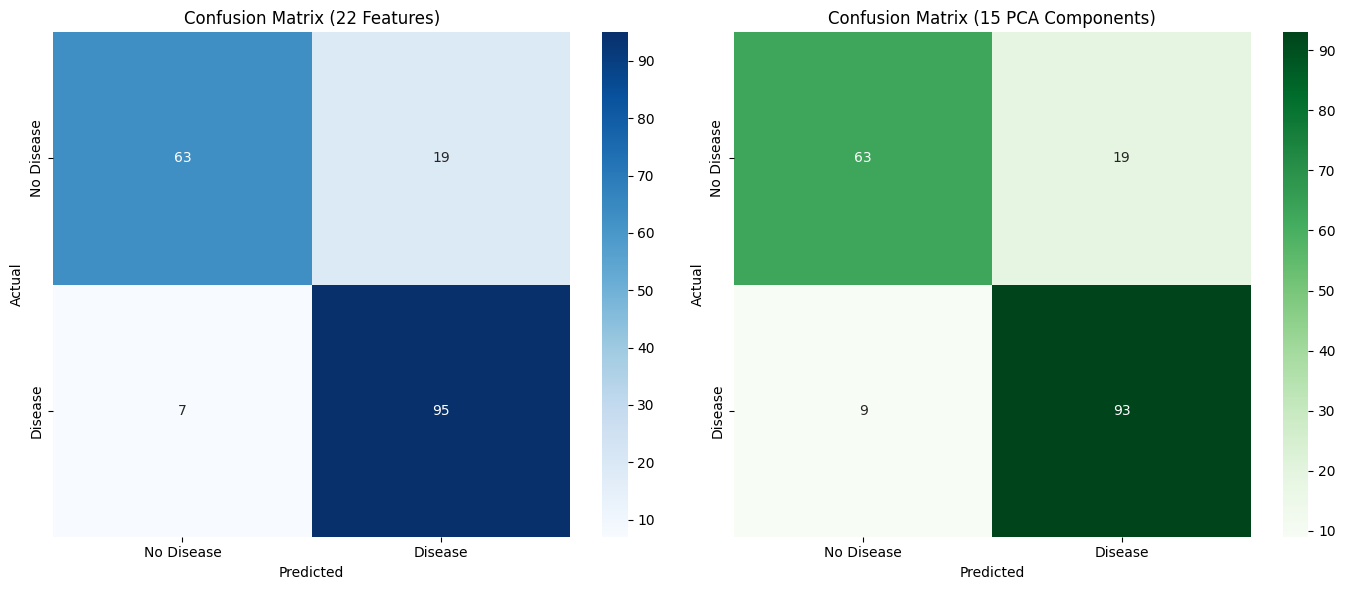


--- CONCLUSION ---
The model with all features achieved an accuracy of 85.87%.
The model using just 15 principal components achieved a very similar accuracy of 84.78%.

This demonstrates that PCA successfully simplified the model by reducing the feature count from 22 to 15 with almost no loss in predictive performance.


In [15]:
# Step 8: Comparing Results & Visualization

# Confusion Matrix for the model with All Features
cm_full = confusion_matrix(y_test, y_pred_full)
# Confusion Matrix for the model with PCA
cm_pca = confusion_matrix(y_test_pca, y_pred_pca)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title(f'Confusion Matrix ({X_train.shape[1]} Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title(f'Confusion Matrix ({X_pca.shape[1]} PCA Components)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

print("\n--- CONCLUSION ---")
print(f"The model with all features achieved an accuracy of {accuracy_score(y_test, y_pred_full) * 100:.2f}%.")
print(f"The model using just {X_pca.shape[1]} principal components achieved a very similar accuracy of {accuracy_score(y_test_pca, y_pred_pca) * 100:.2f}%.")
print(f"\nThis demonstrates that PCA successfully simplified the model by reducing the feature count from {X_train.shape[1]} to {X_pca.shape[1]} with almost no loss in predictive performance.")